# Instrument recognition in musical audio signals
Group 2: Jakob Dittrich, Lea Franz, David Reiter, Thomas Sickinger

**Description**  
This project focuses on instrumental recognition in musical audio signals. The basic plan is to create a machine learning algorithm that identifies a certain group of instruments. 
This will be implemented using the trainings data of the [IRMAS Dataset](https://www.upf.edu/web/mtg/irmas) to learn and test the model. 

**Outcome measurements**  
Precision and Recall are the most important evaluation characteristics but the possible outcomes can also be measured with an accuracy score in percent.

## Setup

In [ ]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from os import listdir
import librosa.display
import pickle
# import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.constraints import MaxNorm

%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# color for plots
pltcolor = '#002b36'
plt.rcParams['figure.figsize'] = [16, 9]

In [ ]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

## Data

The training data contains 6705 audio files in 16 bit stereo wav format sampled at 44.1kHz. They are excerpts of 3 seconds from more than 2000 distinct recordings. The number of files per instrument are: cello (388), clarinet (505), flute (451), acoustic guitar (637), electric guitar (760), organ (682), piano (721), saxophone (626), trumpet (577), violin (580), human voice (778).


The test data contains 2874 excerpts in 16 bit stereo wav format sampled at 44.1kHz.

The music is from different decades, recording and production style and musical genres. There is one predominant target instrument per excerpt.

Source: https://www.upf.edu/web/mtg/irmas

### Loading the data
For loading the audio data we use **librosa**. This is python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems. In this project it is used for loading .wav files,  extracting features and visualizations.

## Analysis of data

### Instrument class balance

In [ ]:
class_dirs = os.listdir('./IRMAS-TrainingData/')
class_dirs.remove('.DS_Store')
class_dirs.remove('README.txt')
class_dirs

['pia',
 'voi',
 '.DS_Store',
 'tru',
 'sax',
 'org',
 'cla',
 'gac',
 'vio',
 'flu',
 'README.txt',
 'gel',
 'cel']

This project uses the following instruments: 

In [ ]:
Instruments = sorted(['vio', 'pia', 'org', 'gel', 'gac', 'voi'])
Instruments

['gac', 'gel', 'org', 'pia', 'vio', 'voi']

The plot shows that the the numbers of samples per instrument are not balanced. The instrument with the most samples is **voi** and the instrument with the least samples is **vio**.

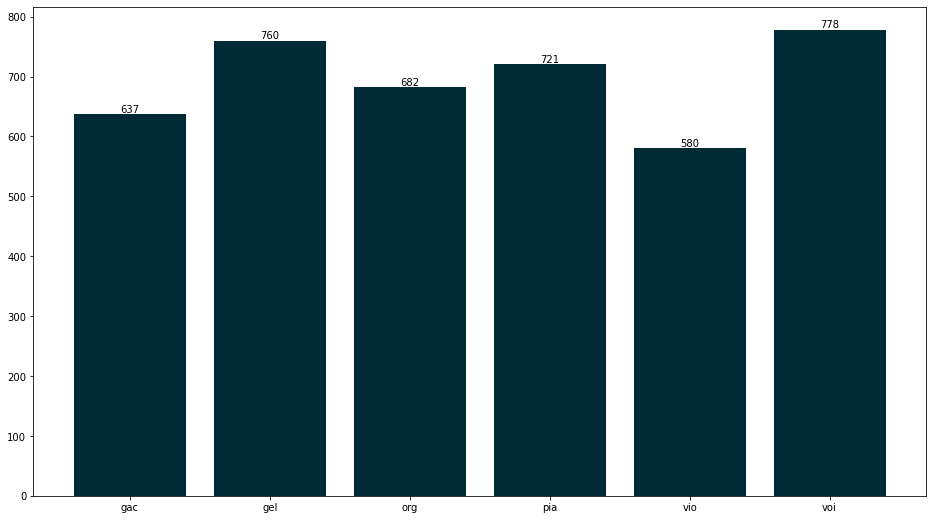

In [ ]:
number_of_files = []
for class_name in Instruments:
    class_dir = os.listdir('./IRMAS-TrainingData/'+class_name)
    number_of_files.append(len(class_dir))

fig, ax = plt.subplots()
bars = ax.bar(Instruments, number_of_files, color=pltcolor);
ax.bar_label(bars);

### Example file

These visualizations of an excerpt including a cello and clarinet without drums show the waveform in the time domain as well as the spectrogram.

In [ ]:
y , sr = librosa.load('./IRMAS-TrainingData/cel/008__[cel][nod][cla]0058__1.wav')

**Waveform in the time domain**

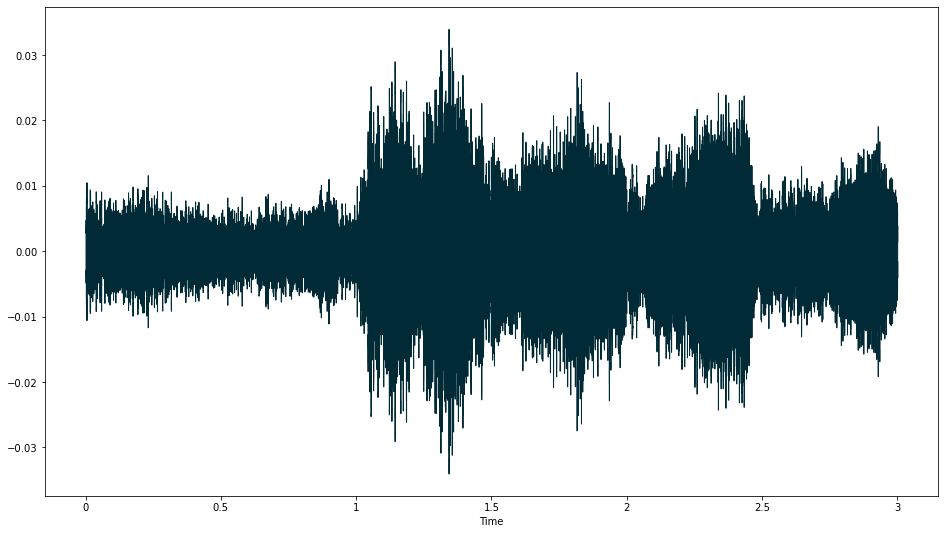

In [ ]:
librosa.display.waveshow(y, sr=sr, color=pltcolor);

**Spectrogram**

A spectrogram is the visual representation of the spectrum of frequencies of a signal over time.

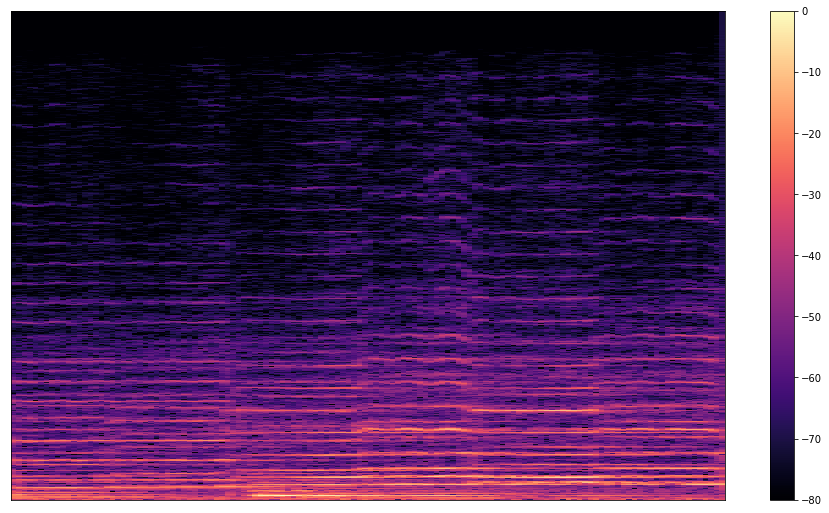

In [ ]:
stft = librosa.stft(y)  # short time fourier transform
magnitudes_to_decibel = librosa.amplitude_to_db(np.abs(stft), ref=np.max) # mapping magnitudes to decibel scale

plt.figure()
librosa.display.specshow(magnitudes_to_decibel)
plt.colorbar();

## Feature extraction

The following features were selected for extraction based on research on audio processing as well as the librosa API:

**Zero Crossing Rate:** the rate at which the signal crosses zero

**Spectral Centroid:** the center of mass in the spectrum

**Spectral Bandwidth:** the weighted average of the frequency signal by its spectrum

**Spectral Roll-Off:** frequency below a specified percentage of the total spectral energy

**Root mean square value:**  the mean value of the signals curve

**Mel-frequency cepstral coefficients:** represent the unique characteristics of a sound

**Melspectrogram:** the spectrogram where the frequencies are converted to the mel scale

In [ ]:
header = 'filename rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate melspectrogram'
for i in range(1, 21): # TODO why 21?
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Creating a .csv file for storing the data from the music files as extracted features

In [ ]:


csv_exists = True

if csv_exists == False:
    file = open('data.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)



In [ ]:


if csv_exists == False:
    file = open('data.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    for i in Instruments:
        for filename in os.listdir(f'./IRMAS-TrainingData/{i}'):
            songname = f'./IRMAS-TrainingData/{i}/{filename}'
            y, sr = librosa.load(songname, sr =44100)
            rms = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            melspec = librosa.feature.melspectrogram(y=y, sr=sr)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} {np.mean(melspec)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {i}'
            file = open('data.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

In [ ]:
df = pd.read_csv('data.csv')
df.head()


,filename,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,melspectrogram,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,[gac][pop_roc]0599__1.wav,0.149846,1765.455284,2316.768276,3881.463788,0.039434,4.478055,-177.740768,183.106140,-39.298458,...,-11.224849,-0.596448,-2.143378,0.162669,0.592024,1.232375,-4.601346,-0.404293,0.554153,gac
1,[gac][pop_roc]0684__3.wav,0.057256,2151.740046,2871.003264,4424.615973,0.041368,0.638174,-244.451920,168.364059,-34.875370,...,-1.734322,-7.018749,-3.163468,-9.860246,-5.122176,-5.768988,-7.969817,3.261638,-2.437297,gac
2,[gac][pop_roc]0730__1.wav,0.115933,1873.659860,2481.265138,4122.319732,0.035081,2.594097,-197.755005,174.568192,-47.049984,...,5.519228,0.744397,-1.831121,0.658741,-2.435940,-1.233488,2.814769,6.446696,-0.061629,gac
3,202__[gac][dru][cou_fol]0673__1.wav,0.150271,4605.320058,4464.928423,10142.637511,0.132926,4.046965,-88.515511,115.689247,-20.837677,...,10.548104,-4.208836,10.606059,-4.000640,0.370844,4.349768,-0.125940,-0.440510,-5.983281,gac
4,[gac][pop_roc]0630__1.wav,0.046989,1068.316666,1511.278029,1623.719911,0.027089,0.552503,-362.860657,197.322754,-0.209483,...,-11.928788,-15.832193,-12.129809,-2.833784,3.045583,0.593217,-0.298925,2.188061,-0.352950,gac


## Analysis of features

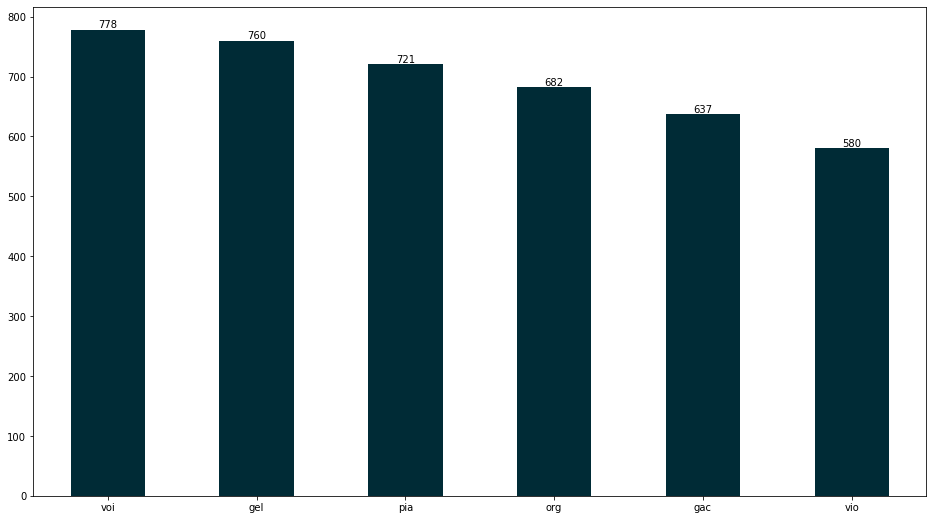

In [ ]:
table = df['label'].value_counts()
ax = table.plot(kind='bar', rot=0, color=pltcolor);
ax.bar_label(ax.containers[0]);

The class imbalance and the number of samples per instrument are still the same after the feature extraction.

### Correlation between features

The most correlated features are spectral_centroid and rolloff, rms and melspectrogram as well as spectral bandwith and rolloff.

In [ ]:
df_corr = df
df_corr.corr().unstack().sort_values().drop_duplicates()

spectral_centroid   mfcc2                -0.832009
mfcc2               spectral_bandwidth   -0.820206
                    rolloff              -0.774466
mfcc4               mfcc2                -0.645317
mfcc6               mfcc2                -0.598631
                                            ...   
spectral_centroid   spectral_bandwidth    0.900877
spectral_bandwidth  rolloff               0.932395
rms                 melspectrogram        0.950055
spectral_centroid   rolloff               0.965179
rms                 rms                   1.000000
Length: 326, dtype: float64

**Highest correlation between spectral_centroid and rolloff**

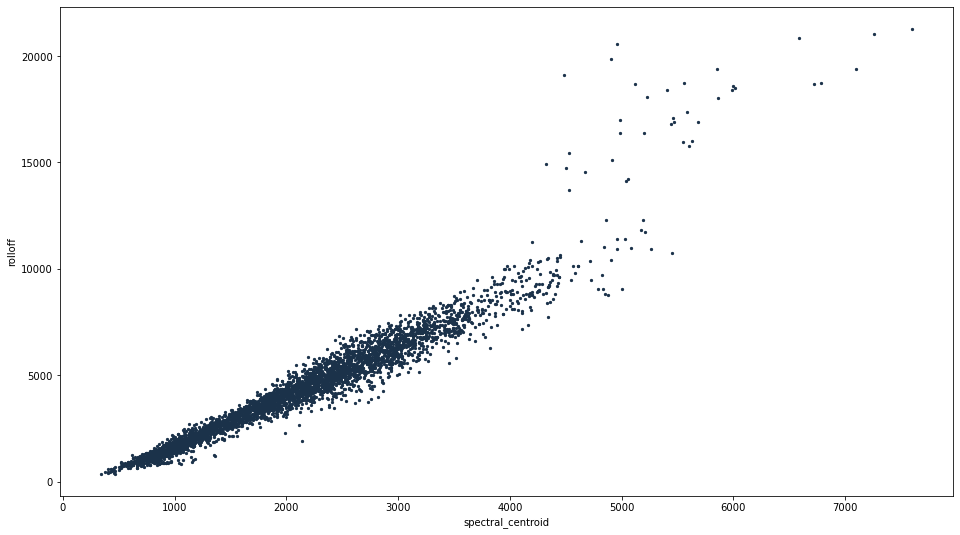

In [ ]:
df.plot.scatter("spectral_centroid", "rolloff", c="#1b324a", marker='.');

## Preprocessing

### NaN values

In [ ]:
df.isnull().values.any()

False

There are no NaN values in this dataset.

### Outliers

The outliers were set to the lower or upper limit instead of removing them to keep more information and improve the model performance.

In [59]:
cols = df.columns.tolist()
cols.remove('label')
cols.remove('filename')

for col in cols:
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    intr_qr = q75-q25

    q_hi = q75+(1.5*intr_qr)
    q_low = q25-(1.5*intr_qr)

    df.loc[df[col] < q_low,col] = q_low
    df.loc[df[col] > q_hi,col] = q_hi
    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

print(str(len(df)-df_filtered)+' rows with outliers detected. Outliers were set to the lower or upper limit.')


ValueError: list.remove(x): x not in list

### Scaling

The data gets scaled with the StandardScaler to change the distribution by which removing the mean and scaling each feature to unit variance. 

Before that, the labels get transformed from strings like voi to numeric values.

In [20]:
# drop filename from dataframe
df = df.drop(['filename'],axis=1)

In [21]:
# extract instrument labels
instru_list = df.iloc[:, -1]
encoder = LabelEncoder()

# encode labels to numeric values
y = encoder.fit_transform(instru_list)
labels = y

df['label'] = y

# uniformly scale data
scaler = StandardScaler()
X_transform = scaler.fit_transform(df.iloc[:, :-1].values)

# save scaler
pickle.dump(scaler, open('./scaler.pkl','wb'))

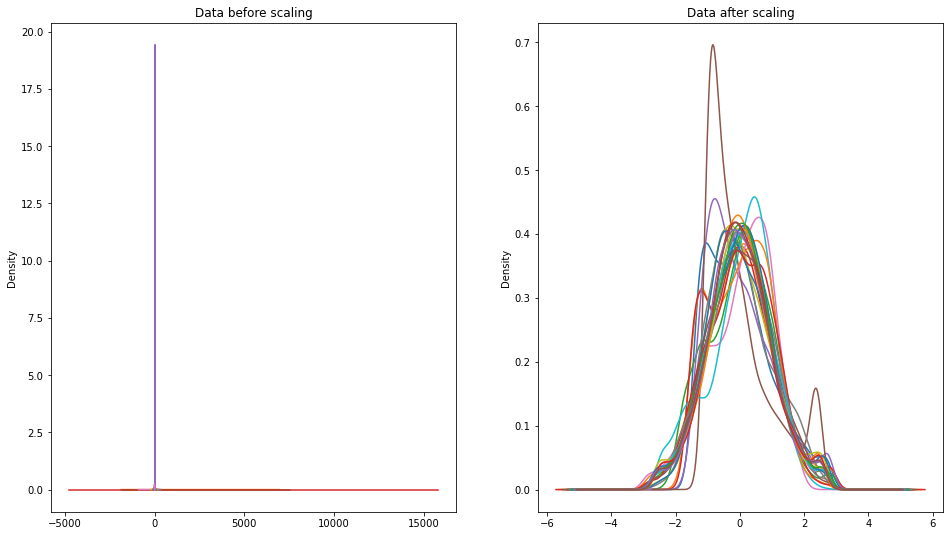

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title("Data before scaling")
ax2.set_title("Data after scaling")

df.plot.density(ax=ax1, legend=False);
df_scaled = pd.DataFrame(X_transform, columns=df.iloc[:, :-1].columns)
df_scaled.plot.density(ax=ax2, legend=False);

In [23]:
# print labels
print('Numberic values instead of class names: ')
print(y)

Numberic values instead of class names: 
[0 0 0 ... 5 5 5]


### Features

The main feature extraction was already done by extracting the features from the .wav files.

#### Feature reduction with PCA

This plot shows the explained variance ratio when 95% of variance is kept. 95% was chosen because otherwise the model performance would decrease too much.    
Feature reduction with PCA  wil be applied later when training the models using a pipeline.

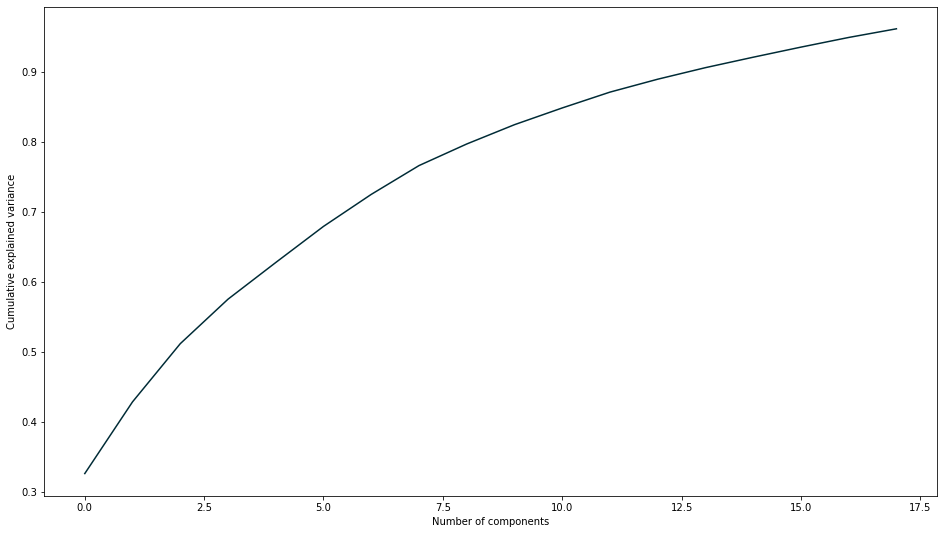

In [24]:
pca = PCA(n_components=0.95)
X_pca = pca.fit(X_transform)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color=pltcolor)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


PCA with 95% variance means 18 components in this case.

In [25]:
X_pca = pca.transform(X_transform)
X_pca.shape

(4158, 18)

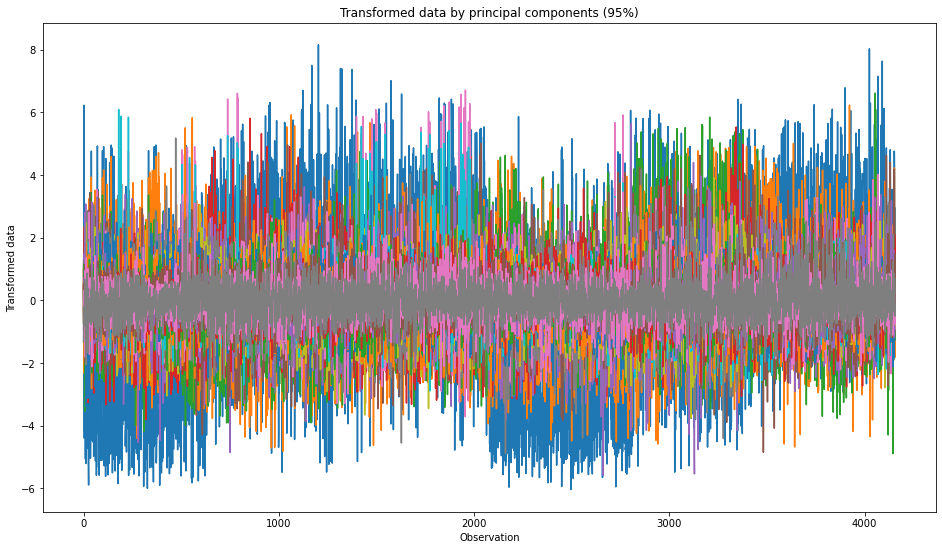

In [26]:
plt.plot(X_pca)
plt.xlabel('Observation')
plt.ylabel('Transformed data')
plt.title('Transformed data by principal components (95%)');

## Models

At this point, the data is sorted by the class labels. Therefore the data has to be shuffled to prevent having all samples from an instrument only in the trainings data and not in the test data.

In [27]:
# shuffle dataframe
df1 = shuffle(df)
df1.head()

,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,melspectrogram,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
4072,0.129685,2429.886020,3068.372088,4779.872255,0.046419,3.679208,-172.658295,149.051620,-26.364351,30.919235,...,-1.460378,-12.111731,-13.061394,-6.809409,-6.698472,-4.499581,-5.674903,-3.557048,-5.041103,5
1041,0.098042,1725.775465,1406.324356,2966.344225,0.068252,1.605874,-263.238770,218.272980,-88.893806,-12.912316,...,-19.616747,-10.326912,-10.519593,-16.223015,-10.544686,-8.499257,-9.967146,-7.925840,-11.431587,1
2908,0.186317,2741.978073,3852.463609,5958.960621,0.044788,6.836048,-120.873825,137.581146,-5.030867,33.493835,...,12.141387,-1.122097,2.636651,-9.961688,-8.205329,-7.450454,-3.775825,-4.002521,2.653632,4
250,0.085748,1556.420486,2807.252656,3203.209459,0.018986,1.573752,-300.293488,151.421448,25.929472,69.971466,...,-3.270578,-2.425093,-4.135430,-0.387049,-5.137856,-1.788424,1.283541,-1.962212,-6.920282,0
967,0.113584,2383.747785,3924.453494,5719.434913,0.027896,3.280262,-223.121140,142.722000,19.229523,38.379623,...,6.739777,-9.878510,-2.379599,-8.996373,-2.186141,-0.533015,1.351596,2.196719,-2.105357,1


To predict how well the model can handle new data which it has not seen before, the data is split into a train/test split. The test data is only used for the best estimator for each model type.

In [28]:
# split dataset in train and test data
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.2)

In [29]:
def print_model_result(predicted_labels):
    print("Recall: ", recall_score(y_test, predicted_labels,average=None))
    print("Recall Average: ", recall_score(y_test, predicted_labels,average="micro"))
    print("Precision: ", precision_score(y_test, predicted_labels,average=None))
    print("Precision Average: ", precision_score(y_test, predicted_labels,average="micro"))
    print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
    print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )
    print("Balanced accuracy: %.2f  ," % balanced_accuracy_score(y_test, predicted_labels), balanced_accuracy_score(y_test, predicted_labels) )

    print("Number of samples:",y_test.shape[0])
    ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels), display_labels=Instruments).plot(cmap="Blues");

The following models were trained and evaluated with hyperparameter search and 10 fold cross validation:
- SVM
- Neural Network
- KNN
- Logistic Regression
- Random Forest

### SVM Model

In [53]:
from sklearn.utils.fixes import loguniform
tuning_params_svm={"C": [3**n for n in range(-5,5)], "gamma": [3**n for n in range(-5,5)], "kernel": ['rbf', 'sigmoid']}
param_grid_svm = {}

for key,value in tuning_params_svm.items():
    hyperparam_key = "classify__" + key
    param_grid_svm[hyperparam_key] = value

In [ ]:
pipe = Pipeline([
        ('classify', SVC())
])

gs = GridSearchCV(pipe, param_grid=param_grid_svm, cv=10, scoring="balanced_accuracy")
gs.fit(X_train, y_train);

In [ ]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))

Best parameters: {'classify__C': 9, 'classify__gamma': 0.1111111111111111, 'classify__kernel': 'rbf'}
Best balanced accuracy score: 0.772455339965604


Recall:  [0.82394366 0.77622378 0.81699346 0.84375    0.72222222 0.78481013]
Recall Average:  0.796875
Precision:  [0.79054054 0.75       0.85616438 0.864      0.67826087 0.82666667]
Precision Average:  0.796875
F1-Score:  [0.80689655 0.7628866  0.8361204  0.85375494 0.69955157 0.80519481]
Accuracy: 0.80  , 663
Balanced accuracy: 0.79  , 0.7946572085087326
Number of samples: 832


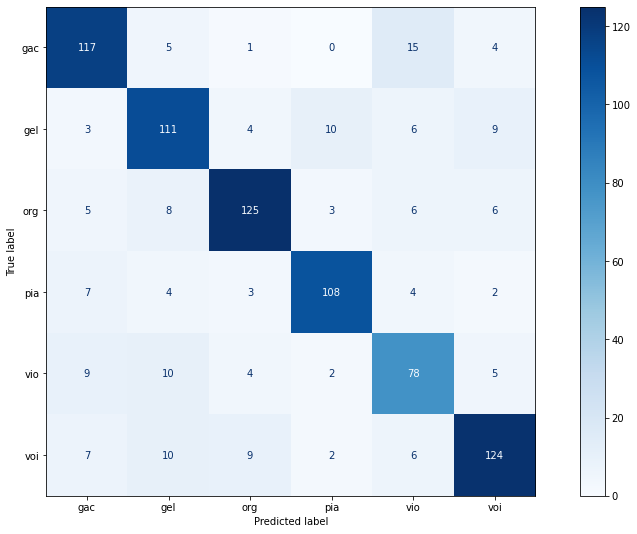

In [ ]:
predicted_labels = gs.best_estimator_.predict(X_test)
predicted_labels_svm = predicted_labels

svm_model = gs.best_estimator_

# save model
pickle.dump(svm_model, open('./model.pkl', 'wb'))

print_model_result(predicted_labels)


### Neural Network

In [82]:
# create a function to build the neural network model
def create_model(neurons):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(26,), kernel_initializer='he_uniform', kernel_constraint=MaxNorm(1)))
    model.add(Dropout(0.1))
    model.add(Dense(6, activation='sigmoid', kernel_initializer='he_uniform'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), metrics=['accuracy'])
    return model

# create the model with KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=100, batch_size=10)

# define the grid search parameters
#param_grid = {'units': [32, 64, 128]}
#param_grid = {'epochs': [10, 50, 100], 'batch_size': [10, 20, 40, 60, 80, 100]}
#param_grid = {'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}
#param_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}
#param_grid = {'init_mode': ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']}
#param_grid = {'weight_constraint': [1.0, 2.0, 3.0, 4.0, 5.0], 'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
param_grid_nn = {'neurons': [1, 5, 10, 15, 20, 25, 30, 64, 128, 256]}

# create the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid_nn, cv=3, n_jobs=-1)

# fit the grid search on the data
grid.fit(X_train, y_train)

# print the best parameters and the corresponding score
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.662664 using {'neurons': 256}
0.300361 (0.009217) with: {'neurons': 1}
0.525559 (0.008015) with: {'neurons': 5}
0.558031 (0.007591) with: {'neurons': 10}
0.578178 (0.014232) with: {'neurons': 15}
0.587189 (0.008289) with: {'neurons': 20}
0.593816 (0.022422) with: {'neurons': 25}
0.601028 (0.013225) with: {'neurons': 30}
0.624778 (0.011587) with: {'neurons': 64}
0.632898 (0.014239) with: {'neurons': 128}
0.662664 (0.014372) with: {'neurons': 256}


26/26 [==============================] - 0s 520us/step
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-01-26 01:32:21         2032
metadata.json                                  2023-01-26 01:32:21           64
variables.h5                                   2023-01-26 01:32:21       121656
Recall:  [0.7238806  0.60402685 0.696      0.74342105 0.6969697  0.80924855]
Recall Average:  0.7163461538461539
Precision:  [0.75193798 0.77586207 0.69047619

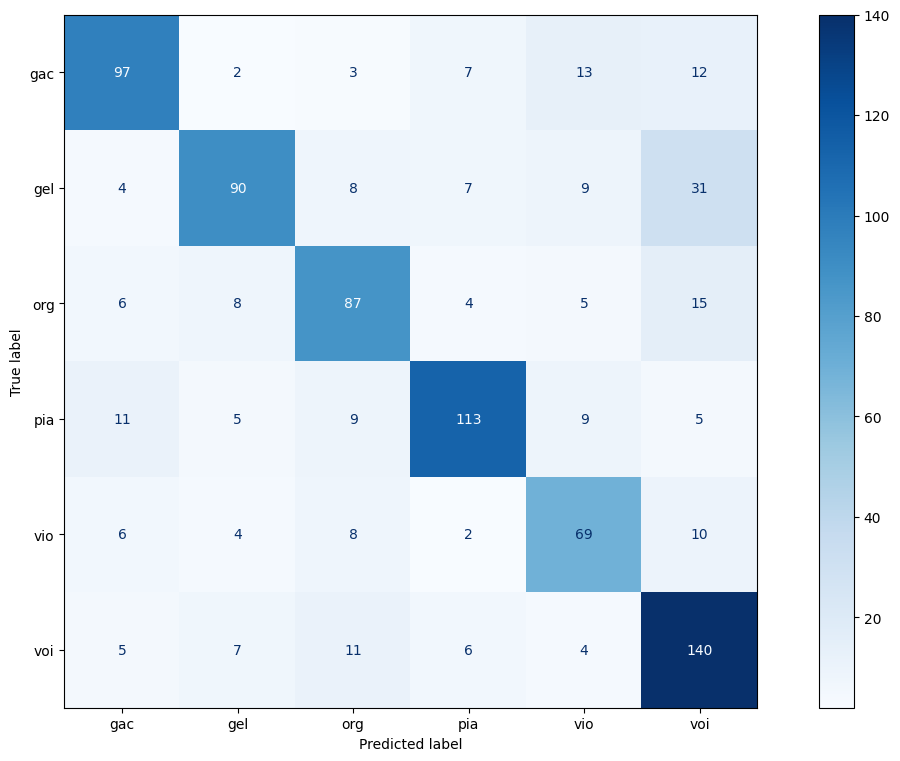

In [87]:
predicted_labels = grid.best_estimator_.predict(X_test)

nn_model = grid.best_estimator_

# save model
pickle.dump(nn_model, open('./nn.pkl', 'wb'))

print_model_result(predicted_labels)

### KNN

In [54]:
knn_hyperparameters = list(range(1, 31))

In [31]:
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=knn_hyperparameters)
  
# defining parameter range
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='balanced_accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

accuracy = grid_search.best_score_ *100
print("Best params: "+str(grid_search.best_params_))
print("Balanced accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'n_neighbors': 1}
Balanced accuracy for our training dataset with tuning is : 75.51%


Recall:  [0.848      0.81818182 0.83098592 0.79562044 0.66115702 0.75352113]
Recall Average:  0.7872596153846154
Precision:  [0.79104478 0.75418994 0.8137931  0.80147059 0.8        0.77536232]
Precision Average:  0.7872596153846154
F1-Score:  [0.81853282 0.78488372 0.82229965 0.7985348  0.7239819  0.76428571]
Accuracy: 0.79  , 655
Balanced accuracy: 0.78  , 0.7845777205308221
Number of samples: 832


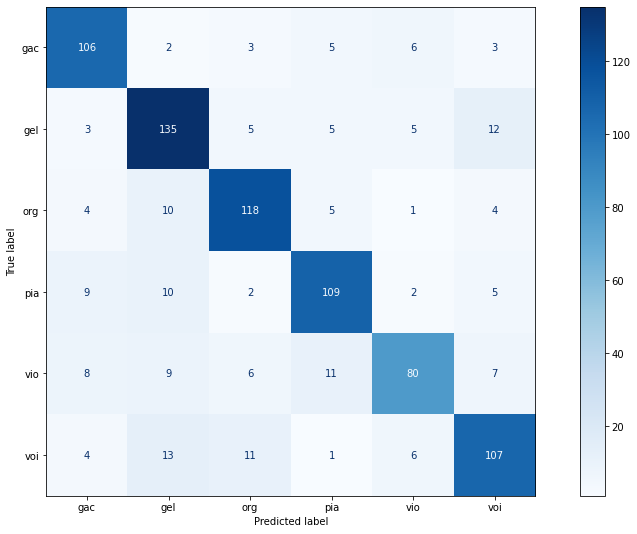

In [32]:
predicted_labels = grid_search.best_estimator_.predict(X_test)

knn_model = grid_search.best_estimator_

# save model
pickle.dump(knn_model, open('./knn.pkl', 'wb'))

print_model_result(predicted_labels)


### Logistic Regression

In [55]:
tuning_params_logr={"C":np.logspace(-4,4,20), "penalty":["l1","l2", "none", "elasticnet"], 'solver': ['lbfgs','newton-cg','liblinear','sag','saga']}# l1 lasso l2 ridge
param_grid_logr = {}

for key,value in tuning_params_logr.items():
    hyperparam_key = "classify__" + key
    param_grid_logr[hyperparam_key] = value

In [95]:
pipe = Pipeline([
        ('classify', LogisticRegression())
])

gs = GridSearchCV(pipe, param_grid=param_grid_logr, cv=10, scoring="balanced_accuracy")
gs.fit(X_train, y_train);

In [96]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))

Best parameters: {'classify__C': 0.0001, 'classify__penalty': 'none', 'classify__solver': 'newton-cg'}
Best balanced accuracy score: 0.5641500404938441


Recall:  [0.52112676 0.43356643 0.49673203 0.7109375  0.47222222 0.51898734]
Recall Average:  0.5240384615384616
Precision:  [0.62184874 0.36470588 0.50331126 0.61073826 0.61445783 0.5125    ]
Precision Average:  0.5240384615384616
F1-Score:  [0.56704981 0.39616613 0.5        0.65703971 0.53403141 0.51572327]
Accuracy: 0.52  , 436
Balanced accuracy: 0.53  , 0.5255953807113298
Number of samples: 832


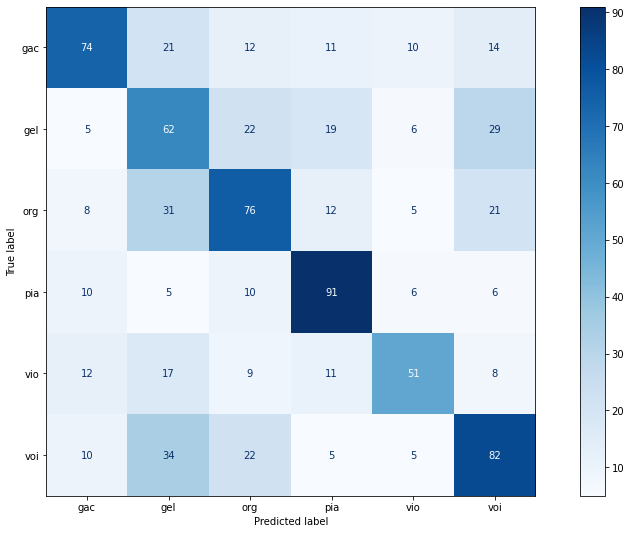

In [97]:
predicted_labels = gs.best_estimator_.predict(X_test)

print_model_result(predicted_labels)


### Random Forest

In [34]:
tuning_params_rf = {
    'max_depth': [30, 40, 50, 60],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200]}


param_grid_rf = {}

for key, value in tuning_params_rf.items():
    hyperparam_key = "classify__" + key
    param_grid_rf[hyperparam_key] = value


In [40]:
# pipe = Pipeline([
#     ('classify', RandomForestClassifier())
# ])
# rf_fit = 

gs = GridSearchCV(RandomForestClassifier(), param_grid=tuning_params_rf,
                  cv=10, scoring="balanced_accuracy")
gs.fit(X_train, y_train);


In [42]:
print('Best parameters: '+str(gs.best_params_))
print('Best balanced accuracy score: '+str(gs.best_score_))
print('Importances of the features: ', gs.best_estimator_.feature_importances_)

Best parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best balanced accuracy score: 0.688918005318485
 [0.04808081 0.035845   0.03610091 0.0418722  0.04509749 0.04854729
 0.05152891 0.03307884 0.05816372 0.04807559 0.04404576 0.04593928
 0.04428219 0.03629955 0.02860764 0.03179761 0.03133164 0.03719081
 0.03257001 0.02965656 0.03087987 0.02866152 0.03388705 0.03145672
 0.02923294 0.03777009]


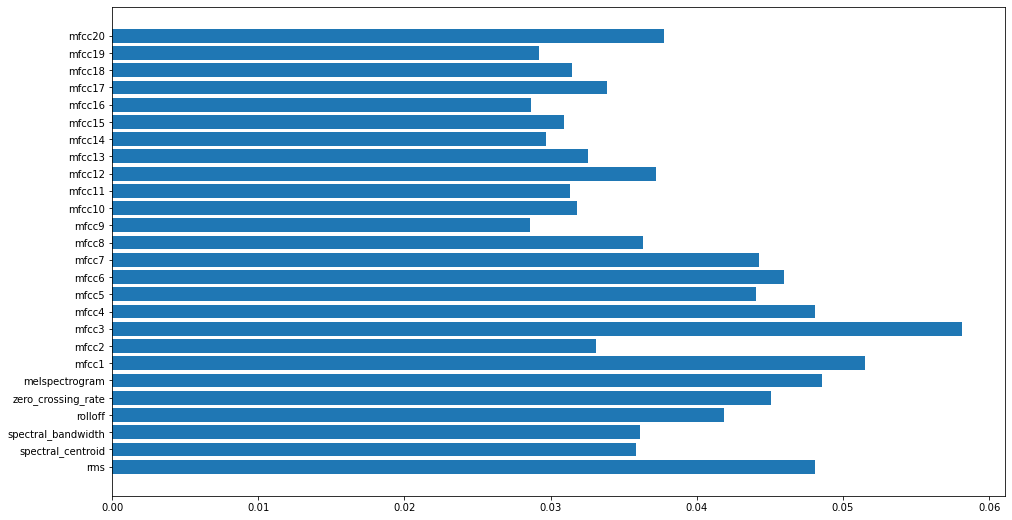

In [50]:
plt.barh(df.iloc[:,:-1].columns, gs.best_estimator_.feature_importances_);


Recall:  [0.744      0.68484848 0.74647887 0.7810219  0.60330579 0.71830986]
Recall Average:  0.7139423076923077
Precision:  [0.76229508 0.71974522 0.70666667 0.74825175 0.82954545 0.59302326]
Precision Average:  0.7139423076923077
F1-Score:  [0.75303644 0.70186335 0.7260274  0.76428571 0.69856459 0.64968153]
Accuracy: 0.71  , 594
Balanced accuracy: 0.71  , 0.7129941500295062
Number of samples: 832


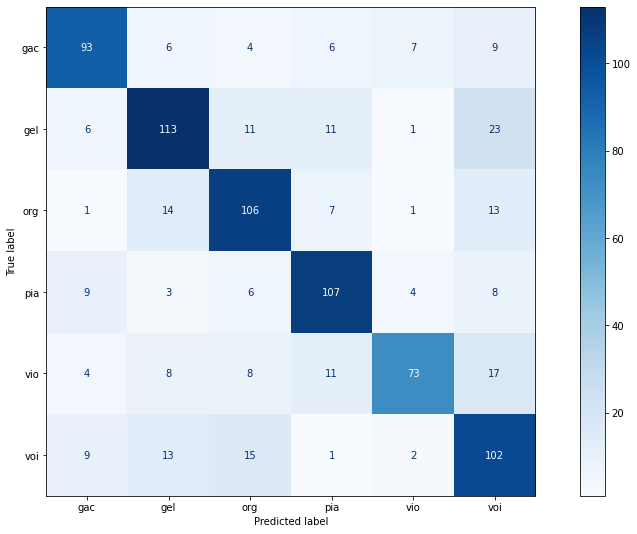

In [37]:
predicted_labels = gs.best_estimator_.predict(X_test)

print_model_result(predicted_labels)

## Evaluation with PCA

In [51]:
# Initialze the estimators
clf1 = SVC()
clf2 = KNeighborsClassifier()
clf3 = LogisticRegression()
#clf4 = KerasClassifier()
clf5 = RandomForestClassifier()

In [56]:
# hyperparameters for each dictionary
param1 = {}
param1['classifier__C'] = tuning_params_svm.get('C')
param1['classifier__gamma'] = tuning_params_svm.get('gamma')
param1['classifier__kernel'] = tuning_params_svm.get('kernel')
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__n_neighbors'] = knn_hyperparameters
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = tuning_params_logr.get('C')
param3['classifier__penalty'] = tuning_params_logr.get('penalty')
param3['classifier'] = [clf3]

# param4 = {}
# param4['classifier__neurons'] = param_grid_nn.get('neurons')
# param4['classifier'] = [clf4]

param5 = {}
param5['classifier__max_depth'] = tuning_params_rf.get('max_depth')
param5['classifier__max_features'] = tuning_params_rf.get('max_features')
param5['classifier__min_samples_leaf'] = tuning_params_rf.get('min_samples_leaf')
param5['classifier__min_samples_split'] = tuning_params_rf.get('min_samples_split')
param5['classifier__n_estimators'] = tuning_params_rf.get('n_estimators')
param5['classifier'] = [clf5]



In [57]:
pipe = Pipeline([
        ('normalization', StandardScaler()),
        ('pca', PCA(n_components=0.95)), 
        ('classifier', clf1)
])
#params = [param1, param2, param3, param4, param5]
params = [param1, param2, param3, param5]

In [58]:
# pca grid search
gs_pca = GridSearchCV(pipe, params, cv=10, scoring='balanced_accuracy').fit(X_train, y_train)


In [60]:
print('Best classifier and parameters: '+str(gs_pca.best_params_))
print('Best balanced accuracy score: '+str(gs_pca.best_score_))
print('Best estimator explained variance: '+str(gs_pca.best_estimator_.steps[1][1].explained_variance_))

Best classifier and parameters: {'classifier': SVC(C=27, gamma=0.1111111111111111), 'classifier__C': 27, 'classifier__gamma': 0.1111111111111111, 'classifier__kernel': 'rbf'}
Best balanced accuracy score: 0.7380703367895004
Best estimator explained variance: [8.54472159 2.61234993 2.15018042 1.6414302  1.37246253 1.31947866
 1.19283723 1.07141065 0.80269283 0.71526235 0.62123772 0.59164567
 0.48452121 0.43147155 0.39314243 0.37680063 0.35420678 0.31961545]


Recall:  [0.816      0.79393939 0.8028169  0.77372263 0.7107438  0.76760563]
Recall Average:  0.7788461538461539
Precision:  [0.82258065 0.71195652 0.82608696 0.85483871 0.70491803 0.77857143]
Precision Average:  0.7788461538461539
F1-Score:  [0.81927711 0.75071633 0.81428571 0.81226054 0.70781893 0.77304965]
Accuracy: 0.78  , 648
Balanced accuracy: 0.78  , 0.77747139309013
Number of samples: 832


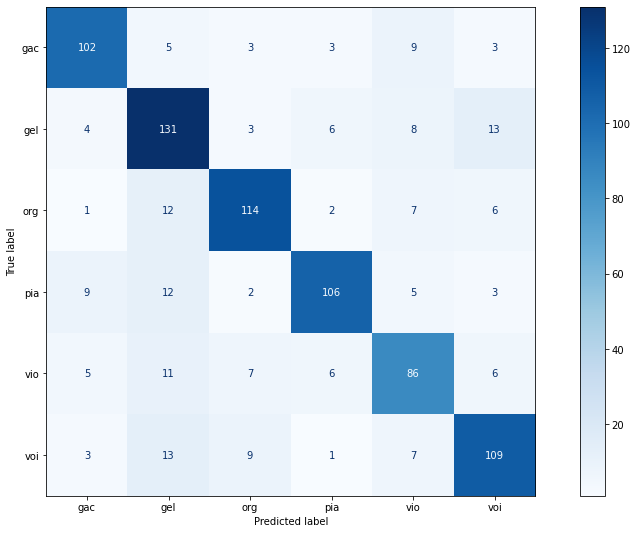

In [61]:
predicted_labels_pca = gs_pca.best_estimator_.predict(X_test)

print_model_result(predicted_labels_pca)

## Conclusion

which instrument the best

explanation which model

Best overall model so far: SVM with all features

In [104]:
print('Recall')
rec_score = recall_score(y_test, predicted_labels_svm,average=None)
for idx, inst in enumerate(Instruments):
    print(inst+': '+str(rec_score[idx]))
print()
print('Precision')
rec_score = precision_score(y_test, predicted_labels_svm,average=None)
for idx, inst in enumerate(Instruments):
    print(inst+': '+str(rec_score[idx]))


Recall
gac: 0.823943661971831
gel: 0.7762237762237763
org: 0.8169934640522876
pia: 0.84375
vio: 0.7222222222222222
voi: 0.7848101265822784

Precision
gac: 0.7905405405405406
gel: 0.75
org: 0.8561643835616438
pia: 0.864
vio: 0.6782608695652174
voi: 0.8266666666666667


In [108]:
def predict_instrument(filename):

    # load model
    #svm_model = pickle.load(open('./model.pkl', 'rb'))

    # load scaler
    #scaler = pickle.load(open('./scaler.pkl','rb'))

    y, sr = librosa.load(filename, sr =44100)
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr)

    columns = ['rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'melspectrogram']
    for i in range(len(mfcc)):
        columns.append('mfcc' + str(i+1))

    rows = [np.mean(rms), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr), np.mean(melspec)]

    for i in mfcc:
        rows.append(np.mean(i))
    
    # create dataframe
    df_test = pd.DataFrame([rows])
    df_test.columns = columns

    # uniformly scale data
    test_transform = scaler.transform(df_test.values)

    return svm_model.predict(test_transform)
    

In [109]:
file_name = './IRMAS-TrainingData/voi/033__[voi][nod][pop_roc]2467__1.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'voi'

In [110]:
file_name = './IRMAS-TrainingData/vio/099__[vio][nod][cla]2172__1.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'vio'

In [111]:
file_name = './IRMAS-TrainingData/gac/040__[gac][nod][cou_fol]0713__2.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'gac'

In [112]:
file_name = './IRMAS-TrainingData/gel/251__[gel][dru][pop_roc]0833__2.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]

'gel'

In [ ]:
file_name = './IRMAS-TestingData-Part1/Part1/00 - gold fronts-12.wav'    
result = predict_instrument(file_name)

Instruments[result[0]]